In [4]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

import torch
#from mlp_train import Net, train, evaluate, detect_digit

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from skimage.morphology import binary_dilation, binary_erosion
from skimage.transform import resize

from six.moves import urllib
from torchvision import datasets
import matplotlib.pyplot as plt
import skimage.io as io

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # fc's
        self.fc1 = nn.Linear(32 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        
        #print(x.shape)
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        
        return x



def load_ds():
    
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    urllib.request.install_opener(opener)

    ############################################################

    num_workers = 0
    # how many samples per batch to load
    batch_size = 20


    # convert data to torch.FloatTensor
    transform = transforms.Compose([transforms.RandomRotation(degrees=25),
                                    transforms.Resize((32,32)),
                                    transforms.ToTensor()
                                    ])

    # choose the training and test datasets
    train_data = datasets.MNIST(root='data', train=True,
                                       download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False,
                                      download=True, transform=transform)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
        num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
        num_workers=num_workers)
        
    return(train_loader,test_loader)
    


def train(n_epochs=30):

    train_loader = load_ds()[0]

    model = Net()
    if train_on_gpu:
        model.cuda()
        
    criterion = nn.CrossEntropyLoss()


    # specify optimizer (stochastic gradient descent) and learning rate = 0.01
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    model.train() # prep model for training

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for data, target in train_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            
        # print training statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1, 
            train_loss
            ))

    #torch.save(model.state_dict(), 'cnn_model_weights.pt')
    return model



def evaluate(model):

    test_loader = load_ds()[1]
    criterion = nn.CrossEntropyLoss()
    batch_size = 20
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # prep model for *evaluation*
    #if train_on_gpu:
    #    model.cuda()

    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass
        print(data.shape)
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))



def detect_digit(img, plot=False):
       
    # image preprocessing
    im = resize(img, (114,114))
    im = im>0.6
    im = np.invert(im)
    #im = binary_erosion(im, [[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])
    im = im*255
    if plot:
        plt.figure()
        plt.imshow(im)
        
    
    
    # Model loading
    model = Net()
    model.load_state_dict(torch.load('cnn_model_weights.pt', map_location=torch.device('cpu')))
    model.eval()
    
    im = np.uint8(im)
   
    transform1 = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Grayscale(),
                                    transforms.Resize((32,32)),
                                    #transforms.ToTensor()
                                    ])
    
    transform2 = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor()
                                    ])
    
    
    print(im)
    
    im = transform1(im)
    im = np.array(im)
    im = resize(im, (1,1,32,32))
    im = transform2(im)
    
    #im = ToTensor()(img)
    
    output = model(im)
    _, preds = torch.max(output, 1)
    return preds.detach().numpy()[0]
    

CUDA is not available.  Training on CPU ...


In [3]:
### Testing ############################
model = Net()
model.load_state_dict(torch.load('cnn_model_weights.pt', map_location=torch.device('cpu')))
#print(model)
evaluate(model)

torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 3

torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 32, 32])
torch.Size([20, 1, 3

In [9]:
def detect_digit(img, plot=False):
       
    # image preprocessing
    im = resize(img, (114,114))
    im = im>0.6
    im = np.invert(im)
    #im = binary_erosion(im, [[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])
    im = im*255
    im = resize(im, (32,32))
    if plot:
        plt.figure()
        plt.imshow(im)
        
    # Model loading
    model = Net()
    model.load_state_dict(torch.load('cnn_model_weights.pt', map_location=torch.device('cpu')))
    model.eval()
    
    im = np.uint8(im)
   
    transform1 = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor()
                                    ]) 
    im = transform1(im)

    output = model(im.view(1,1,32,32))
    _, preds = torch.max(output, 1)
    return preds.detach().numpy()[0]

tensor([8])


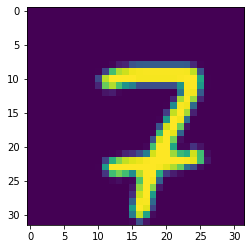

In [5]:
data_transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor()
                                ])

im = io.imread('seven.jpeg',as_gray=True)
im = resize(im, (114,114))
im = im>0.6
im = np.invert(im)
#im = binary_erosion(im, [[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])
im = im*255

im = resize(im, (32,32))
plt.figure()
plt.imshow(im)

im = np.uint8(im)

img = im
img = data_transform(img)

model.eval()

idx = torch.topk(model(img.view(1,1,32,32)),1)
print(idx[1][0])

TypeError: Input type float64 is not supported

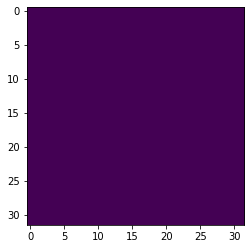

In [10]:
## Use Case #######################
p = detect_digit(io.imread('seven.jpeg',as_gray=True), plot=True)
print('Pridection: ', p)